Loading Data...
Loaded 50414 training samples and 14404 testing samples.


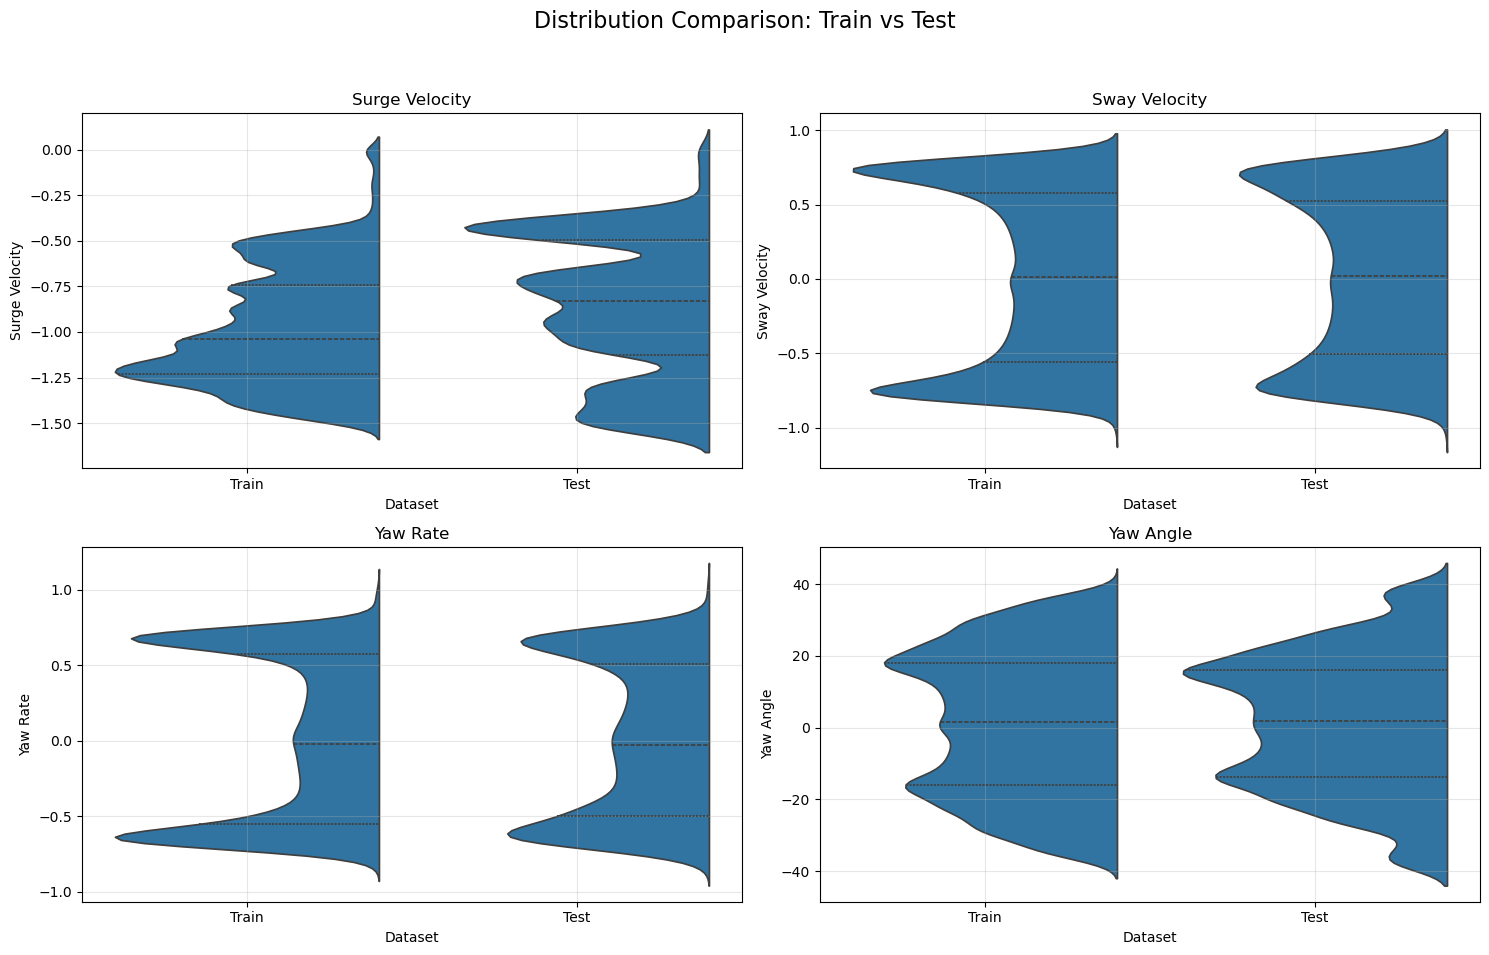

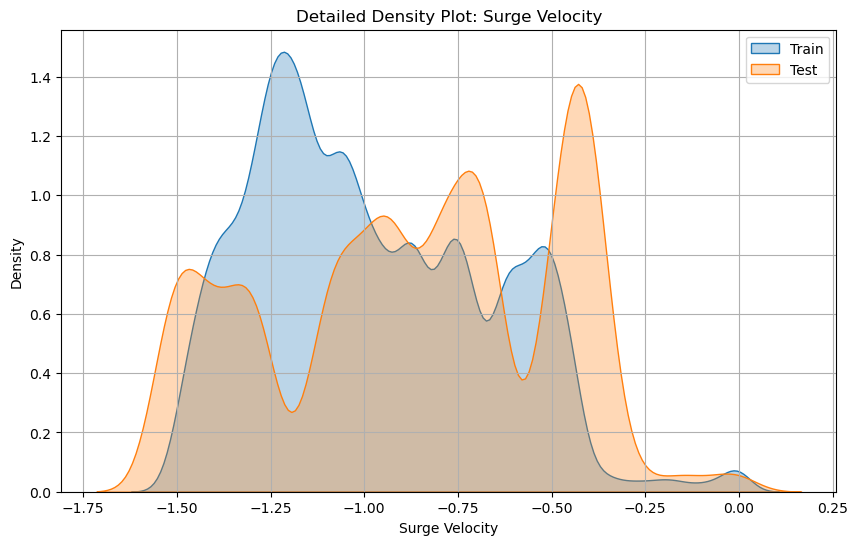

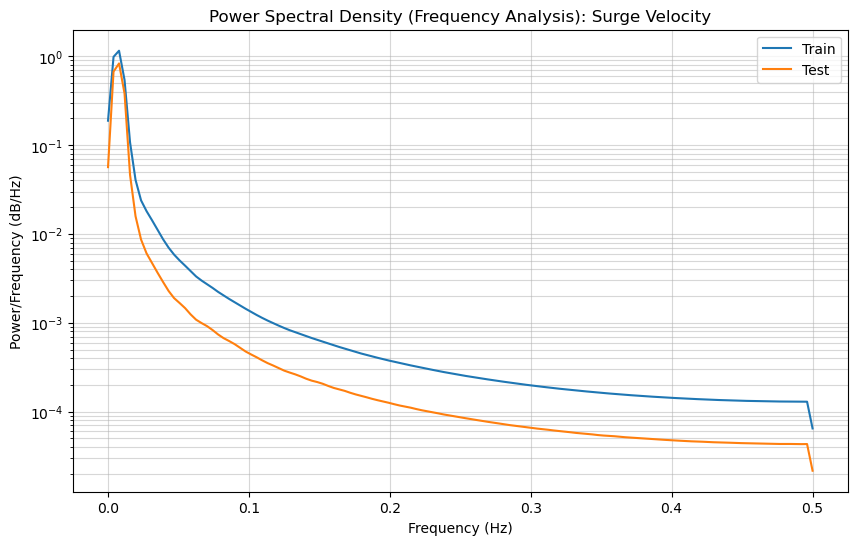

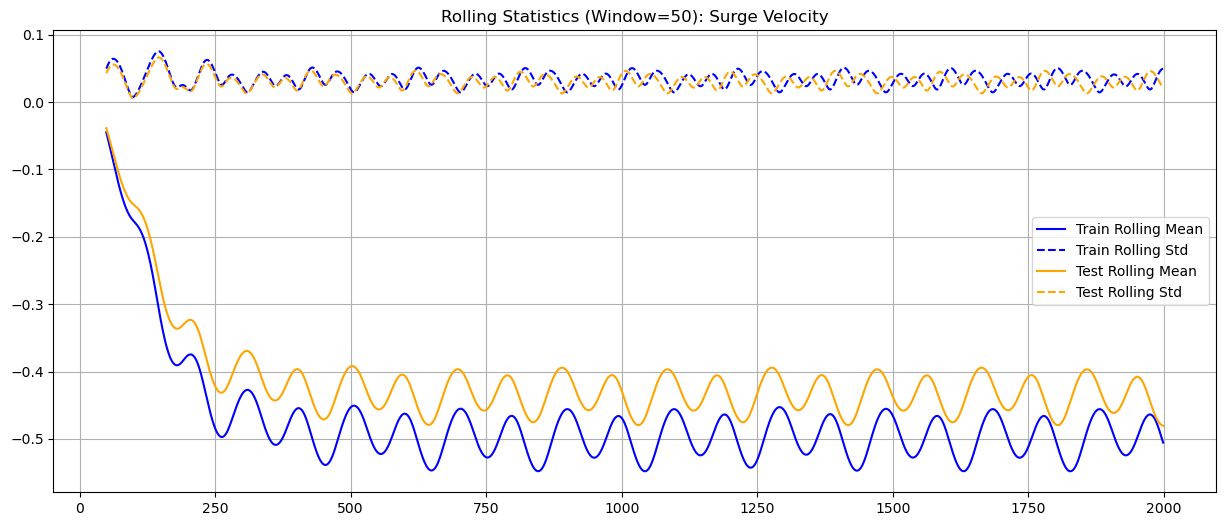

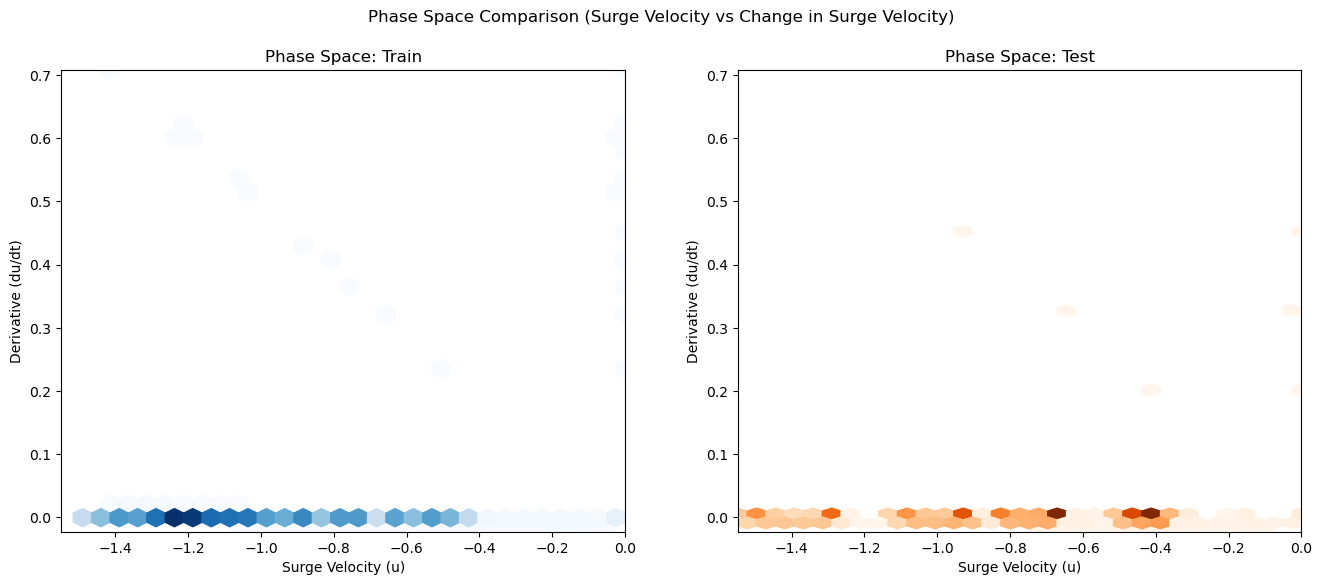

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# ==========================================
# 1. CONFIGURATION & DATA LOADING
# ==========================================
# Update these paths if your folder structure is different
DATASET_PATH = 'dataset' 
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Features to analyze
# Based on your CSV headers, these seem to be the 4 targets
FEATURES = ['Surge Velocity', 'Sway Velocity', 'Yaw Rate', 'Yaw Angle']
TARGET_OF_INTEREST = 'Surge Velocity'  # The one failing

def load_data(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = []
    for filename in all_files:
        df = pd.read_csv(filename)
        df['source_file'] = os.path.basename(filename)
        df_list.append(df)
    
    if not df_list:
        raise ValueError(f"No CSV files found in {folder_path}")
        
    return pd.concat(df_list, ignore_index=True)

print("Loading Data...")
try:
    train_df = load_data(TRAIN_PATH)
    test_df = load_data(TEST_PATH)
    
    # Label them for plotting
    train_df['Dataset'] = 'Train'
    test_df['Dataset'] = 'Test'
    
    print(f"Loaded {len(train_df)} training samples and {len(test_df)} testing samples.")
except Exception as e:
    print(f"Error loading data: {e}")
    # Create dummy data for demonstration if files aren't found
    print("Creating dummy data for demonstration...")
    t = np.linspace(0, 100, 1000)
    train_df = pd.DataFrame({
        'Surge Velocity': 5 + np.sin(t), 
        'Sway Velocity': np.cos(t),
        'Yaw Rate': 0.1*np.sin(t),
        'Yaw Angle': np.sin(0.5*t),
        'Dataset': 'Train'
    })
    test_df = pd.DataFrame({
        'Surge Velocity': 8 + 2*np.sin(2*t), # Shifted mean & freq
        'Sway Velocity': np.cos(t),
        'Yaw Rate': 0.1*np.sin(t),
        'Yaw Angle': np.sin(0.5*t),
        'Dataset': 'Test'
    })

combined_df = pd.concat([train_df, test_df], ignore_index=True)

# ==========================================
# 2. DISTRIBUTION ANALYSIS (Violin & KDE)
# ==========================================
# This checks for Covariate Shift: Has the range or mean changed?

plt.figure(figsize=(15, 10))
plt.suptitle(f'Distribution Comparison: Train vs Test', fontsize=16)

for i, feature in enumerate(FEATURES):
    plt.subplot(2, 2, i+1)
    
    # Violin plot shows the density and the range
    sns.violinplot(data=combined_df, x='Dataset', y=feature, split=True, inner="quart")
    
    plt.title(feature)
    plt.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Focus on the problematic target with a detailed KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_df, x=TARGET_OF_INTEREST, fill=True, label='Train', alpha=0.3)
sns.kdeplot(data=test_df, x=TARGET_OF_INTEREST, fill=True, label='Test', alpha=0.3)
plt.title(f'Detailed Density Plot: {TARGET_OF_INTEREST}')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 3. FREQUENCY DOMAIN ANALYSIS (PSD)
# ==========================================
# This checks if the oscillation frequency has changed (Concept Drift)

def plot_psd(data, label, fs=1.0):
    # fs = 1.0 assuming 1 second sampling, adjust if known
    freqs, psd = signal.welch(data, fs=fs, nperseg=min(len(data), 256))
    plt.semilogy(freqs, psd, label=label)

plt.figure(figsize=(10, 6))
plot_psd(train_df[TARGET_OF_INTEREST], 'Train')
plot_psd(test_df[TARGET_OF_INTEREST], 'Test')
plt.title(f'Power Spectral Density (Frequency Analysis): {TARGET_OF_INTEREST}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# ==========================================
# 4. ROLLING STATISTICS (Time Domain Dynamics)
# ==========================================
# This checks for non-stationarity (drifting mean/variance)

# We take a slice of data to avoid overplotting if dataset is huge
window_size = 50
train_slice = train_df.iloc[:2000]
test_slice = test_df.iloc[:2000]

plt.figure(figsize=(15, 6))

# Plot Train
plt.plot(train_slice[TARGET_OF_INTEREST].rolling(window=window_size).mean(), 
         label='Train Rolling Mean', color='blue')
plt.plot(train_slice[TARGET_OF_INTEREST].rolling(window=window_size).std(), 
         label='Train Rolling Std', color='blue', linestyle='--')

# Plot Test
plt.plot(test_slice[TARGET_OF_INTEREST].rolling(window=window_size).mean(), 
         label='Test Rolling Mean', color='orange')
plt.plot(test_slice[TARGET_OF_INTEREST].rolling(window=window_size).std(), 
         label='Test Rolling Std', color='orange', linestyle='--')

plt.title(f'Rolling Statistics (Window={window_size}): {TARGET_OF_INTEREST}')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 5. PHASE SPACE RECONSTRUCTION
# ==========================================
# This checks the physics: Plot Velocity (u) vs Acceleration (du/dt)
# If the "loops" don't overlap, the Test set contains physics not seen in Train.

def plot_phase_space(df, dataset_name, ax, color_map):
    # Estimate derivative (acceleration)
    u = df[TARGET_OF_INTEREST].values
    du = np.gradient(u)
    
    # Use hexbin for large datasets to see density
    hb = ax.hexbin(u, du, gridsize=30, cmap=color_map, mincnt=1)
    ax.set_title(f'Phase Space: {dataset_name}')
    ax.set_xlabel(f'{TARGET_OF_INTEREST} (u)')
    ax.set_ylabel(f'Derivative (du/dt)')
    return hb

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_phase_space(train_df, 'Train', ax1, 'Blues')
plot_phase_space(test_df, 'Test', ax2, 'Oranges')

# Set same limits for fair comparison
xlims = (min(combined_df[TARGET_OF_INTEREST]), max(combined_df[TARGET_OF_INTEREST]))
ylims = (min(np.gradient(combined_df[TARGET_OF_INTEREST])), max(np.gradient(combined_df[TARGET_OF_INTEREST])))

ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)

plt.suptitle(f'Phase Space Comparison ({TARGET_OF_INTEREST} vs Change in {TARGET_OF_INTEREST})')
plt.show()

Loading Data...
Loaded 14404 training samples and 3601 testing samples.


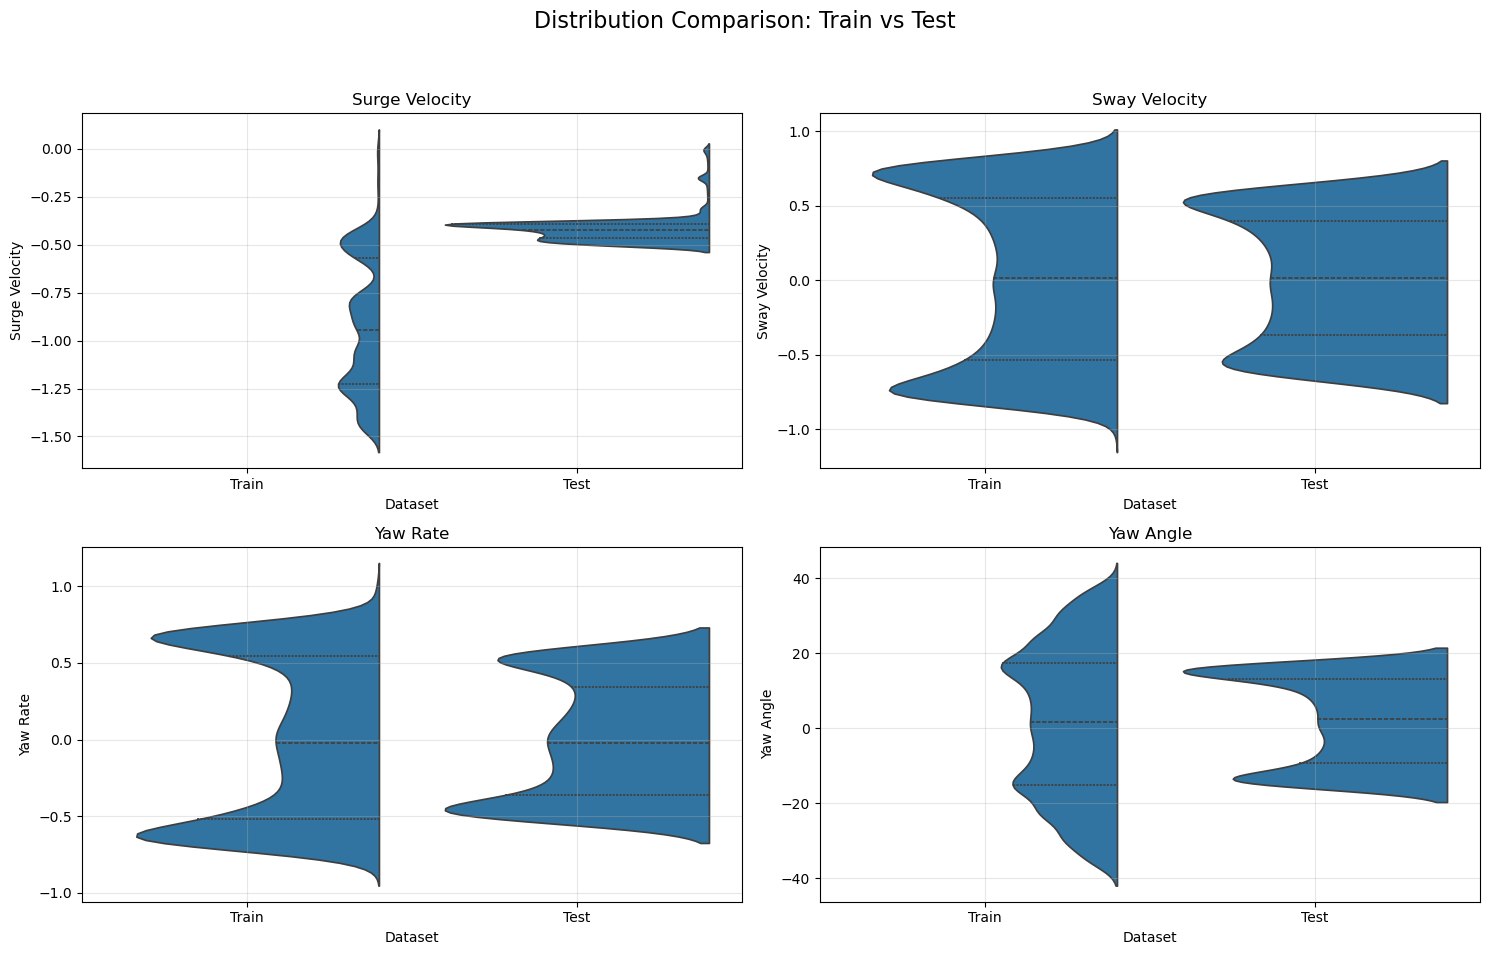

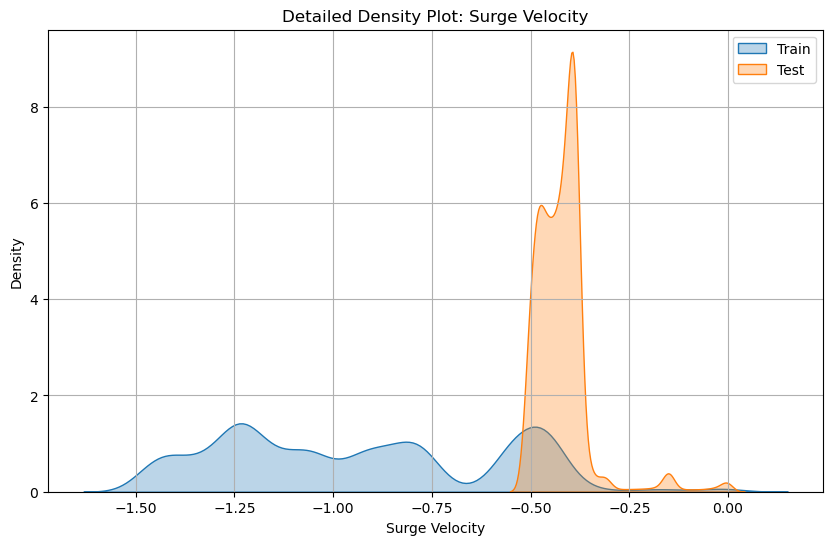

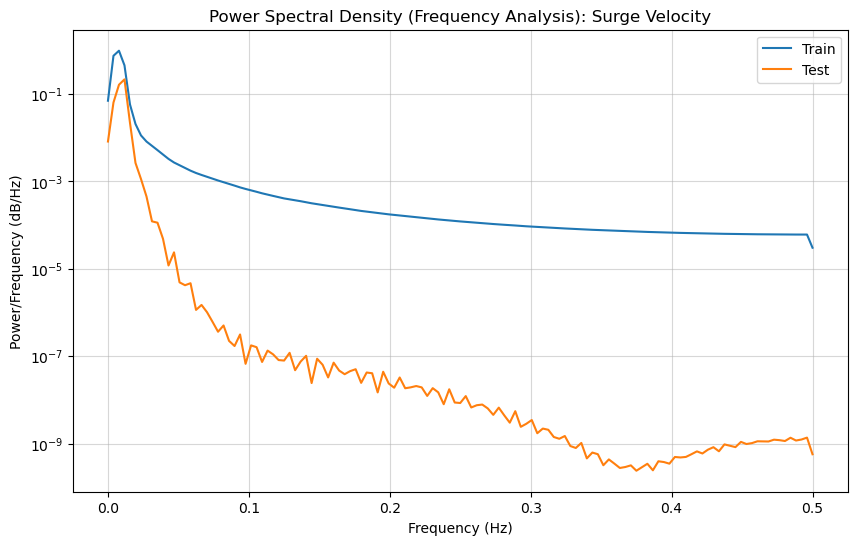

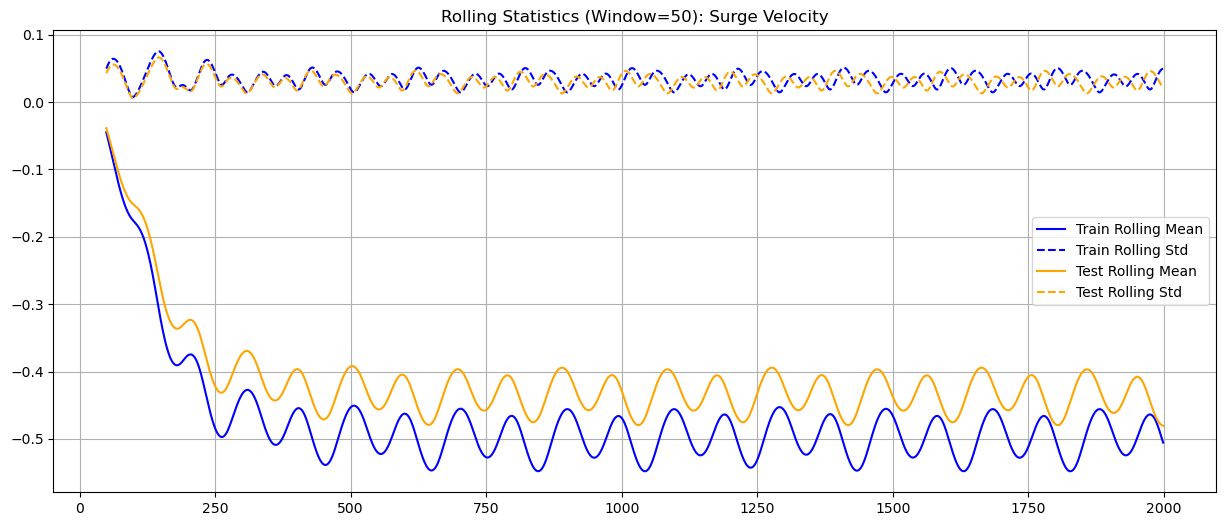

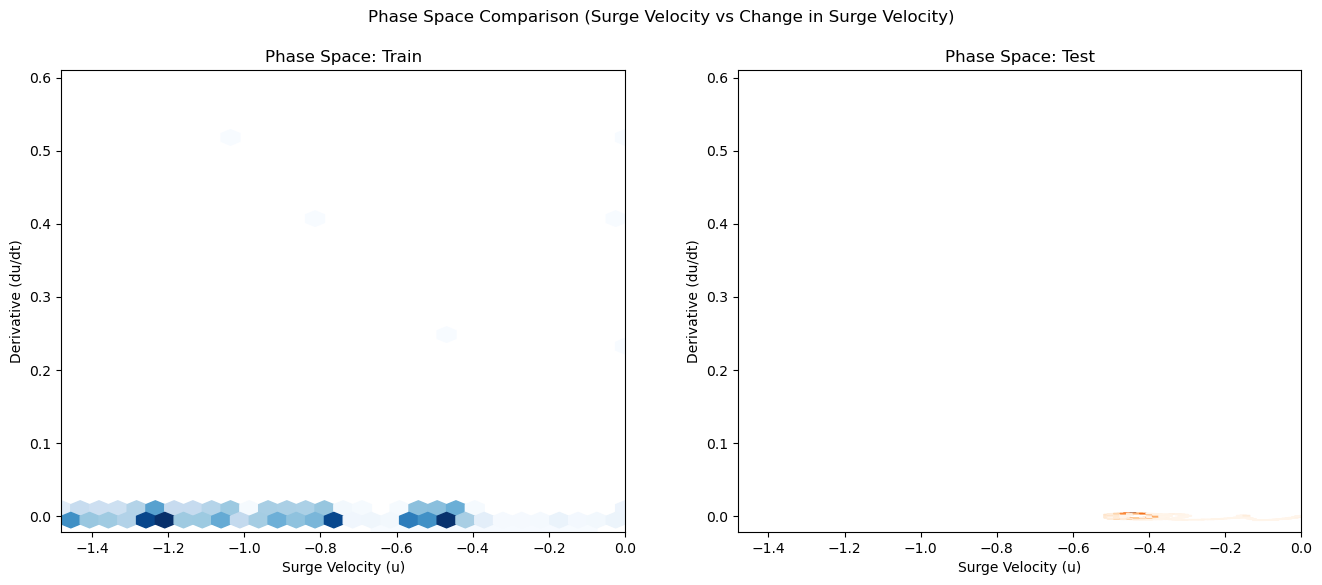

In [2]:
# ==========================================
# 1. CONFIGURATION & DATA LOADING
# ==========================================
# Update these paths if your folder structure is different
DATASET_PATH = 'reduce_dataset' 
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Features to analyze
# Based on your CSV headers, these seem to be the 4 targets
FEATURES = ['Surge Velocity', 'Sway Velocity', 'Yaw Rate', 'Yaw Angle']
TARGET_OF_INTEREST = 'Surge Velocity'  # The one failing

def load_data(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = []
    for filename in all_files:
        df = pd.read_csv(filename)
        df['source_file'] = os.path.basename(filename)
        df_list.append(df)
    
    if not df_list:
        raise ValueError(f"No CSV files found in {folder_path}")
        
    return pd.concat(df_list, ignore_index=True)

print("Loading Data...")
try:
    train_df = load_data(TRAIN_PATH)
    test_df = load_data(TEST_PATH)
    
    # Label them for plotting
    train_df['Dataset'] = 'Train'
    test_df['Dataset'] = 'Test'
    
    print(f"Loaded {len(train_df)} training samples and {len(test_df)} testing samples.")
except Exception as e:
    print(f"Error loading data: {e}")
    # Create dummy data for demonstration if files aren't found
    print("Creating dummy data for demonstration...")
    t = np.linspace(0, 100, 1000)
    train_df = pd.DataFrame({
        'Surge Velocity': 5 + np.sin(t), 
        'Sway Velocity': np.cos(t),
        'Yaw Rate': 0.1*np.sin(t),
        'Yaw Angle': np.sin(0.5*t),
        'Dataset': 'Train'
    })
    test_df = pd.DataFrame({
        'Surge Velocity': 8 + 2*np.sin(2*t), # Shifted mean & freq
        'Sway Velocity': np.cos(t),
        'Yaw Rate': 0.1*np.sin(t),
        'Yaw Angle': np.sin(0.5*t),
        'Dataset': 'Test'
    })

combined_df = pd.concat([train_df, test_df], ignore_index=True)

# ==========================================
# 2. DISTRIBUTION ANALYSIS (Violin & KDE)
# ==========================================
# This checks for Covariate Shift: Has the range or mean changed?

plt.figure(figsize=(15, 10))
plt.suptitle(f'Distribution Comparison: Train vs Test', fontsize=16)

for i, feature in enumerate(FEATURES):
    plt.subplot(2, 2, i+1)
    
    # Violin plot shows the density and the range
    sns.violinplot(data=combined_df, x='Dataset', y=feature, split=True, inner="quart")
    
    plt.title(feature)
    plt.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Focus on the problematic target with a detailed KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_df, x=TARGET_OF_INTEREST, fill=True, label='Train', alpha=0.3)
sns.kdeplot(data=test_df, x=TARGET_OF_INTEREST, fill=True, label='Test', alpha=0.3)
plt.title(f'Detailed Density Plot: {TARGET_OF_INTEREST}')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 3. FREQUENCY DOMAIN ANALYSIS (PSD)
# ==========================================
# This checks if the oscillation frequency has changed (Concept Drift)

def plot_psd(data, label, fs=1.0):
    # fs = 1.0 assuming 1 second sampling, adjust if known
    freqs, psd = signal.welch(data, fs=fs, nperseg=min(len(data), 256))
    plt.semilogy(freqs, psd, label=label)

plt.figure(figsize=(10, 6))
plot_psd(train_df[TARGET_OF_INTEREST], 'Train')
plot_psd(test_df[TARGET_OF_INTEREST], 'Test')
plt.title(f'Power Spectral Density (Frequency Analysis): {TARGET_OF_INTEREST}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# ==========================================
# 4. ROLLING STATISTICS (Time Domain Dynamics)
# ==========================================
# This checks for non-stationarity (drifting mean/variance)

# We take a slice of data to avoid overplotting if dataset is huge
window_size = 50
train_slice = train_df.iloc[:2000]
test_slice = test_df.iloc[:2000]

plt.figure(figsize=(15, 6))

# Plot Train
plt.plot(train_slice[TARGET_OF_INTEREST].rolling(window=window_size).mean(), 
         label='Train Rolling Mean', color='blue')
plt.plot(train_slice[TARGET_OF_INTEREST].rolling(window=window_size).std(), 
         label='Train Rolling Std', color='blue', linestyle='--')

# Plot Test
plt.plot(test_slice[TARGET_OF_INTEREST].rolling(window=window_size).mean(), 
         label='Test Rolling Mean', color='orange')
plt.plot(test_slice[TARGET_OF_INTEREST].rolling(window=window_size).std(), 
         label='Test Rolling Std', color='orange', linestyle='--')

plt.title(f'Rolling Statistics (Window={window_size}): {TARGET_OF_INTEREST}')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 5. PHASE SPACE RECONSTRUCTION
# ==========================================
# This checks the physics: Plot Velocity (u) vs Acceleration (du/dt)
# If the "loops" don't overlap, the Test set contains physics not seen in Train.

def plot_phase_space(df, dataset_name, ax, color_map):
    # Estimate derivative (acceleration)
    u = df[TARGET_OF_INTEREST].values
    du = np.gradient(u)
    
    # Use hexbin for large datasets to see density
    hb = ax.hexbin(u, du, gridsize=30, cmap=color_map, mincnt=1)
    ax.set_title(f'Phase Space: {dataset_name}')
    ax.set_xlabel(f'{TARGET_OF_INTEREST} (u)')
    ax.set_ylabel(f'Derivative (du/dt)')
    return hb

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_phase_space(train_df, 'Train', ax1, 'Blues')
plot_phase_space(test_df, 'Test', ax2, 'Oranges')

# Set same limits for fair comparison
xlims = (min(combined_df[TARGET_OF_INTEREST]), max(combined_df[TARGET_OF_INTEREST]))
ylims = (min(np.gradient(combined_df[TARGET_OF_INTEREST])), max(np.gradient(combined_df[TARGET_OF_INTEREST])))

ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)

plt.suptitle(f'Phase Space Comparison ({TARGET_OF_INTEREST} vs Change in {TARGET_OF_INTEREST})')
plt.show()